<a href="https://colab.research.google.com/github/yexf308/MAT592/blob/main/Module1/Neural_Networks3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline 
import numpy.linalg as LA
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


## Deep Neural Network
- Define the model structure (such as number of input features and hidden layers, activation functions and cost functions)

- Initialize the model’s parameters.

- Loop till the minimum value of cost function:  

  - Calculate current loss (**forward propagation**).

  - Calculate current gradient (**backward propagation**).

  - Update parameters (**stochastic gradient descent**)




---
# Implement Deep Neural Network from scratch 

### Activation functions and Cost functions
Here we implemented sigmoid function as our activation function in hidden neuron layer and the output layer. 


In [ ]:
 ##@title  Activation functions and Cost functions

def Sigmoid(z,derivative=False):
  """Compute logistic function (sigmoid) or its derivative"""
  sigma = 1. / (1. + exp(-clip(z, -250, 250)))  
  if derivative:
    return sigma * (1-sigma) 
  return sigma 
  

def Square_loss(A,Y,derivative=False):
  """Compute square loss or its derivative"""
  error = A-Y
  if derivative:
    return error

  cost = 1/2*dot(error, error) 
  return cost


def Logistic_loss(A,Y, derivative=False):
  """Compute logistic loss or its derivative"""
  if derivative:
    num = A - Y
    dem = A * (1-A) # this is equal to g'(Z)
    return num/dem

  cost = -dot(log(A), Y) - dot(log(1-A), 1-Y)
  return cost


In [ ]:
##@title Encode labels 

def onehot(y, n_classes):
  """Encode labels into one-hot representation

  Parameters
  ------------
  y : array, shape = [n_examples]
      Target values.
  n_classes : int
      Number of classes

  Return
  -----------
  onehot : array, shape = (n_examples, n_classes)

  """
  onehot = zeros((n_classes, y.shape[0]))
  for idx, val in enumerate(y.astype(int)):
    onehot[val, idx] = 1.
  return onehot.T


In [ ]:

##@title Initialize parameters.
def init_params(layer_dim):
  """initialize two parameters 
  in each layer: Weight W and Bias b.

  Input
  -----------
  layer_dim: array, shape = [N_layer]
      the number of neuron in each layer 

  Return  
  -----------
  params: dictionary
       i.e. params[‘W1’] will represent 
        the weight matrix for layer 1.
   
  """
  np.random.seed(3)
  params = {}
  L = len(layer_dim)
    
  for l in range(1, L):
    params['W'+str(l)] = random.randn(layer_dim[l], layer_dim[l-1])*1/sqrt(layer_dim[l-1])
    params['b'+str(l)] = random.randn(layer_dim[l])
        
  return params

### Forward Propagation
  A_prev is input to the previous layer. 
  We will loop through all the layers of the network and 
  will compute the linear transformation. 
  After that it will take the value of Z 
  and will give it to the activation function. 
  Cache values are stored along the way 
  and are accumulated in caches. 
  Finally, the function will return the value generated 
  and the stored cache.

In [ ]:
##@title Forward Propagation
def forward_prop(x, params,activation=Sigmoid):
  """
  Input
  -----------
  x: training data
  params: Parameters as dictionary
  activation: activation function

  Return  
  -----------
  A: Final layer output, \vec a^{(L)}(x)
  caches: intermediate values stored, everything before applying activation function
  (\vec a^{(l-1)}, \vec z^{(l)})

  """  
  A = x # input to first layer i.e. training data
  caches = []
  L = len(params)//2
  for l in range(L):
    A_prev = A
        
    # Linear transformation 
    Z = np.dot(params['W'+str(l+1)], A_prev) + params['b'+str(l+1)] 
        
    # storing the both linear and activation cache
    cache = (A_prev, Z)
    caches.append(cache)

    # Applying activation function on linear transformation
    A  = activation(Z) 
  return A, caches


### Backward Propagation
 we created a dictionary for mapping gradients to each layer. We loop through the model in a backwards direction and compute the gradient. The detailed algorithm is in Neural Networks2.ipynb

In [ ]:
##@title Backward Propagation
def backward_prop(AL, Y, caches, params, loss_function=Square_loss, activation=Sigmoid):
  """
  Input
  -----------
  AL: Final layer output, \vec a^{(L)}(x^{(i)})

  Y: one hot vector of the label y^{(i)}

  caches: intermediate values stored, everything before applying activation function
  (\vec a^{(l-1)}, \vec z^{(l)}), l=1,2,\dots,L

  params: Parameters as dictionary, params[W1], \dots, params[WL], params[b1],\dots, params[bL]

  loss_function: choice of loss function, by default is square loss

  activation: choice of activation function, by defauly is sigmoid function.

  Output
  -----------
  grads: gradients as dictionary, grads[W1], \dots, grads[WL],grads[b1],\dots, grads[bL]
  """
  grads = {}
  L = len(caches)
  AL1, ZL = caches[L-1] 
  delta_L = loss_function(AL, Y, derivative=True) * activation(ZL, derivative=True)
  grads['db'+str(L)] = delta_L
  grads['dW'+str(L)] = array([delta_L]).T  @ array([AL1])
  delta_prev = delta_L

  for l in reversed(range(L-1)):
    delta_curr  = delta_prev
    A_prev, Z_curr = caches[l]
    W_curr  = params['W'+str(l+2)]
    delta_prev = dot(W_curr.T, delta_curr) * activation(Z_curr, derivative=True)
    grads['db'+str(l+1)] = delta_prev
    grads['dW'+str(l+1)] = array([delta_prev]).T  @ array([A_prev])

  return grads


### SGD method to update parameter
Here we only implemented SGD method. 


In [ ]:
def update_parameters(params, grads, learning_rate, method='SGD'):
  L = len(params) // 2
  if method == 'SGD':
    for l in range(L):
      params['W'+str(l+1)] = params['W'+str(l+1)] -learning_rate*grads['dW'+str(l+1)]
      params['b'+str(l+1)] = params['b'+str(l+1)] -learning_rate*grads['db'+str(l+1)]

  return params    


### Training neural network

In [ ]:

def train_NN(Xtrain,Ytrain_vec, epochs, layer_dim, learning_rate,cost_function, activation_function):
  # Step 2 initialize gradient based algorithm
  params = init_params(layer_dim)
  N      = Xtrain.shape[0]
  cost_span = zeros(epochs)

  # Step 3: training the neural network
  arr = arange(N)
  for i in range(epochs):
    l_rate   = learning_rate[i]
    random.shuffle(arr)
    cost_i = 0
    for j in arr:
      Y_hat, caches = forward_prop(Xtrain[j], params, activation = activation_function) # sub step 1
      cost_i += cost_function(Y_hat,Ytrain_vec[j])
      grads  = backward_prop(Y_hat, Ytrain_vec[j], caches, params, loss_function=cost_function, activation=activation_function) #sub step 2
      params = update_parameters(params, grads, l_rate) # sub step 3
    cost_span[i] = cost_i/N  
    print(['At epochs ', i, 'the cost is ', cost_i/N])

  return params, cost_span  


### Prediction

In [ ]:
def prediction(params, Xtest):
  N = Xtest.shape[0]
  Ypred = zeros(N)
  for j in range(N):
    Y_hat, caches = forward_prop(Xtest[j], params, activation = activation_function)
    Ypred[j] = argmax(Y_hat)

  return Ypred


In [ ]:
def plot_decision_boundaries(params,Xtrain, Ytrain, boundary_margin =0.1, resolution=200,activation_type='Sigmoid', cost_type='Square loss'):
  mins = Xtrain.min(axis=0) - boundary_margin
  maxs = Xtrain.max(axis=0) + boundary_margin
  xx, yy = np.meshgrid(linspace(mins[0], maxs[0], resolution),
                       linspace(mins[1], maxs[1], resolution))
  Ypred = prediction(params, np.c_[xx.ravel(), yy.ravel()])
  N = Ypred.shape[0]
  Ypred = Ypred.reshape(xx.shape)
  fig=figure()
  plt.contourf(Ypred, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
  plt.contour(Ypred, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
  plt.scatter(Xtrain[:,0],Xtrain[:,1],c=Ytrain)
  plt.title(f"activation function: {activation_type}, cost function: {cost_type}")
  



---
# Generate training and testing data set
We test our algorithm with the following dataset. 


In [ ]:
##@title Generating Spiral Data
def gen_data(n=100, d=2, c=3, std=0.2):
  X = zeros([n * c, d])
  y = zeros(n * c)
  for i in range(c):
    index = 0
    r = linspace(0.2, 1, n)
    t = linspace( i * 2 * pi / c, (i + 2) * 2 * pi / c, n) + randn(n) * std

    for ix in range(n * i, n * (i + 1)):
      X[ix] = r[index] * array([sin(t[index]), cos(t[index])])
      y[ix] = i
      index += 1
  return X, y     





---
# Setup neural network
Here we use the shallow neural network, i.e., only one hidden neuron layer with 32 neurons. The input layer has 2 neurons since the dimension of the feature is 2. The output layer has 3 neurons since number of classes to be classified is 3. 

We first choose square loss function as cost function and then choose logistic loss function. We will compare the performance for both functions. 


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 0. 0.]


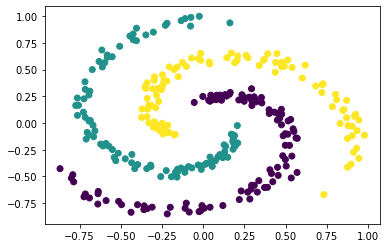

In [ ]:
# Step 0: generate 300 training data and 150 testing data
n_class =3
Xtrain, Ytrain = gen_data(n=100, c=n_class)
Xtest, Ytest   = gen_data(n=50, c=n_class)

# this is important to remove the mean. So it can scale well.
Xtrain_mean              = np.mean(Xtrain, axis=0)
Xtrain = Xtrain - Xtrain_mean

Xtest_mean              = np.mean(Xtest, axis=0)
Xtest = Xtest - Xtest_mean

scatter(Xtrain[:,0],Xtrain[:,1],c=Ytrain)
print(Ytrain)

# turn Ytrain  into one-hot vector
Ytrain_vec = onehot(Ytrain, n_classes=n_class)
print(Ytrain_vec[1])


In [ ]:
# Step 1: initialize neural network. we start with shallow. 

layer_dim = [Xtrain.shape[1], 32, n_class]
cost_function       = Square_loss #Logistic_loss 
activation_function = Sigmoid
epochs = 100
epochs_span = arange(epochs)
learning_rate = 1/((epochs_span+1)**0.1) 

# step 2 and 3
params_square, cost_span_square = train_NN(Xtrain,Ytrain_vec, epochs, layer_dim, learning_rate,cost_function, activation_function)


['At epochs ', 0, 'the cost is ', 0.3428303308226156]
['At epochs ', 1, 'the cost is ', 0.3071414231617628]
['At epochs ', 2, 'the cost is ', 0.2943761875043789]
['At epochs ', 3, 'the cost is ', 0.2852967659093126]
['At epochs ', 4, 'the cost is ', 0.2871645495168917]
['At epochs ', 5, 'the cost is ', 0.27784086592672014]
['At epochs ', 6, 'the cost is ', 0.2721658735201403]
['At epochs ', 7, 'the cost is ', 0.2699063445931708]
['At epochs ', 8, 'the cost is ', 0.26815669740170583]
['At epochs ', 9, 'the cost is ', 0.26692676773980123]
['At epochs ', 10, 'the cost is ', 0.2598880667928238]
['At epochs ', 11, 'the cost is ', 0.25710187756823916]
['At epochs ', 12, 'the cost is ', 0.2522886351128371]
['At epochs ', 13, 'the cost is ', 0.2478879326512802]
['At epochs ', 14, 'the cost is ', 0.23733569242741553]
['At epochs ', 15, 'the cost is ', 0.2218659066870692]
['At epochs ', 16, 'the cost is ', 0.20892282694501943]
['At epochs ', 17, 'the cost is ', 0.19331523445427878]
['At epochs '

In [ ]:
cost_function  = Logistic_loss 
params_Log, cost_span_Log = train_NN(Xtrain,Ytrain_vec, epochs, layer_dim, learning_rate,cost_function, activation_function)


['At epochs ', 0, 'the cost is ', 2.048256960347052]
['At epochs ', 1, 'the cost is ', 1.6292777819586426]
['At epochs ', 2, 'the cost is ', 1.511795358860148]
['At epochs ', 3, 'the cost is ', 1.4194352326567221]
['At epochs ', 4, 'the cost is ', 1.3644699445439636]
['At epochs ', 5, 'the cost is ', 1.1668022810993923]
['At epochs ', 6, 'the cost is ', 0.9893347256388817]
['At epochs ', 7, 'the cost is ', 0.7755293315792561]
['At epochs ', 8, 'the cost is ', 0.6259888444554884]
['At epochs ', 9, 'the cost is ', 0.4818449539091081]
['At epochs ', 10, 'the cost is ', 0.37018324942062736]
['At epochs ', 11, 'the cost is ', 0.3006886652063717]
['At epochs ', 12, 'the cost is ', 0.3022806667737294]
['At epochs ', 13, 'the cost is ', 0.2010720030652963]
['At epochs ', 14, 'the cost is ', 0.18047596505180685]
['At epochs ', 15, 'the cost is ', 0.16992681938726187]
['At epochs ', 16, 'the cost is ', 0.1957926335681066]
['At epochs ', 17, 'the cost is ', 0.12807298099768244]
['At epochs ', 18,

In [ ]:
# test on Xtest Ytest 
Ypred_square=prediction(params_square, Xtest)
Ypred_Log=prediction(params_Log, Xtest)
N = Xtest.shape[0]
print('For square loss, error rate is ', norm(Ypred_square - Ytest, 0)/N )
print('For Logistic loss, error rate is ', norm(Ypred_Log - Ytest, 0)/N )
# it is almost 100% correct!

For square loss, error rate is  0.013333333333333334
For Logistic loss, error rate is  0.006666666666666667


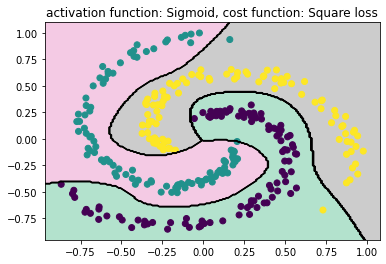

In [ ]:
plot_decision_boundaries(params_square,Xtrain, Ytrain, resolution=200, cost_type='Square loss')

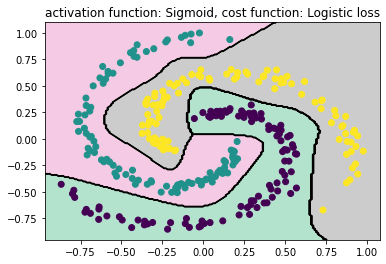

In [ ]:
plot_decision_boundaries(params_Log,Xtrain, Ytrain, resolution=200,cost_type='Logistic loss')

Text(0, 0.5, 'cost')

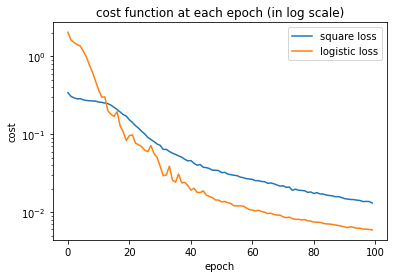

In [ ]:
fig,ax = plt.subplots()
ax.set_yscale('log')
ax.plot(epochs_span, cost_span_square,label = 'square loss')
ax.plot(epochs_span, cost_span_Log, label ='logistic loss')
legend()
plt.title('cost function at each epoch (in log scale)')
plt.xlabel('epoch')
plt.ylabel('cost')

# Practical issues and techniques for improvement
## The learning slowdown issue 

Remind that in the square loss
\begin{align}
&\frac{\partial C_i}{\partial \mathbf{W}^{(L)}} = \left(\mathbf{a}^{(L)}-\mathbf{y}^{(i)}\right)\circ g'(\mathbf{z}^{(L)})\cdot (\mathbf{a}^{(L-1)})^\top\\ 
& \frac{\partial C_i}{\partial \mathbf{b}^{(L)}} = \left(\mathbf{a}^{(L)}-\mathbf{y}^{(i)}\right)\circ g'(\mathbf{z}^{(L)})
\end{align}

When $g$ is sigmoid function and $\mathbf{z}^{(L)}$ is initially large in magnitude, $g'(\mathbf{z}^{(L)})\approx 0$, this shows that both $\mathbf{W}^{(L)}$ and $\mathbf{b}^{(L)}$  will
initially learn very slowly.

If we use the logistic loss,
\begin{align}
&\frac{\partial C_i}{\partial \mathbf{W}^{(L)}} = \frac{\partial C_i}{\partial \mathbf{a}^{(L)}}\circ g'(\mathbf{z}^{(L)})\cdot (\mathbf{a}^{(L-1)})^\top = \left(\mathbf{a}^{(L)}-\mathbf{y}^{(i)}\right)\cdot(\mathbf{a}^{(L-1)})^\top \\
& \frac{\partial C_i}{\partial \mathbf{b}^{(L)}} =\frac{\partial C_i}{\partial \mathbf{a}^{(L)}}\circ g'(\mathbf{z}^{(L)}) = \left(\mathbf{a}^{(L)}-\mathbf{y}^{(i)}\right)
\end{align}
We can show $g'(\mathbf{z}^{(L)})$ is gone, so so that gradient descent will move fast when $\mathbf{a}^{(L)}$ is far away from $\mathbf{y}^{(i)}$.

## Overfitting

Neural networks are likely to overfit especially when
given insufficient training data, due to their enormouse parameters. 

We can add a regularization term of the form $\lambda \|\mathbf{W}\|_p$ to any cost function used in order to avoid overfitting. Typical choices of $p$ are $p=2$ ($L_2$-regularization) and $p=1$ ($L_1$-regularization). 

**You can implement it by yourself!**

## Initialize weights and biases
- The biases $\mathbf{b}^{(l)}$ for all neurons are initialized as standard Gaussian random variables.

- For the weight $\mathbf{W}^{(l)}$,  initialize the input weights as Gaussian random variables with mean 0 and standard deviation $\frac{1}{\sqrt{h^{(l-1)}}}$, where $h^{(l-1)}$ is the number of input weights to this neuron.

The reason is the total input to the neuron $\mathbf{z}^{(l)}= \mathbf{W}^{(l)}\mathbf{a}^{(l-1)}+\mathbf{b}^{(l)}$ has small standard deviation around zero so that the neuron starts in the middle, not from the two ends. 

## How to set the hyper-parameters
Parameter tuning for neural networks is hard and often requires specialist knowledge.

- Start with subsets of data and small networks. For example, in MNIST dataset, train a $(784, 10)$ network and $(784, 32, 10)$ network.

- Monitor the validation accuracy more often, say, after every 1000
training dataset. Play with the parameters in order to get quick feedback from experiments.

- Once things get improved, vary each hyperparameter separately (while fixing the rest) until the result stops improving (though this may only give you a locally optimal combination).



## Relu activation function
In my code, I use sigmoid function $\sigma$ through out all layers including the output layer. Recently, Relu becomes more popular choice of activation function. 

**Do it yourself**: Modify my code to use Relu in these hidden nueron layer and sigmoid/softmax function in the output layer. Compare the performance with sigmoid. 

**Do it yourself**:  Implement stochastic gradient methods with momentum and with Nesterov momentum.

# (If Time Permitted)What really happened in neural network?

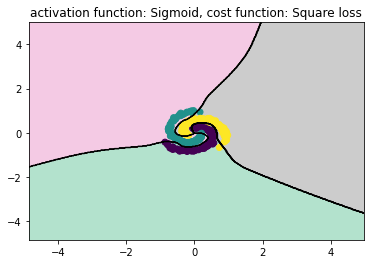

In [ ]:
plot_decision_boundaries(params_square,Xtrain, Ytrain,boundary_margin=4, resolution=400, cost_type='Square loss')

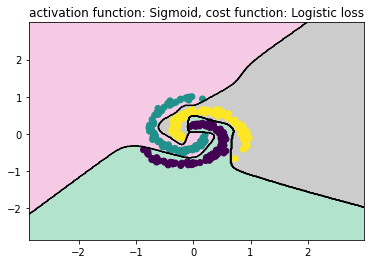

In [ ]:
plot_decision_boundaries(params_Log,Xtrain, Ytrain,boundary_margin=2, resolution=400, cost_type='Logistic loss')

In [ ]:
layer_dim_new = [Xtrain.shape[1], 32, 2, n_class]
cost_function       = Square_loss
params_square_new, cost_span_square = train_NN(Xtrain,Ytrain_vec, epochs, layer_dim_new, learning_rate,cost_function, activation_function)


['At epochs ', 0, 'the cost is ', 0.34473732832618625]
['At epochs ', 1, 'the cost is ', 0.33094870134129845]
['At epochs ', 2, 'the cost is ', 0.31658252808764475]
['At epochs ', 3, 'the cost is ', 0.3053112367826544]
['At epochs ', 4, 'the cost is ', 0.2983048459296162]
['At epochs ', 5, 'the cost is ', 0.29621638312934234]
['At epochs ', 6, 'the cost is ', 0.29432024513897914]
['At epochs ', 7, 'the cost is ', 0.2917469454993063]
['At epochs ', 8, 'the cost is ', 0.2851616558736532]
['At epochs ', 9, 'the cost is ', 0.28035309038171824]
['At epochs ', 10, 'the cost is ', 0.27230924062048983]
['At epochs ', 11, 'the cost is ', 0.2653081788345299]
['At epochs ', 12, 'the cost is ', 0.2603254662311798]
['At epochs ', 13, 'the cost is ', 0.2591392651023043]
['At epochs ', 14, 'the cost is ', 0.24998673629060056]
['At epochs ', 15, 'the cost is ', 0.24685122365047918]
['At epochs ', 16, 'the cost is ', 0.24463399097924138]
['At epochs ', 17, 'the cost is ', 0.24295889186191014]
['At epoc

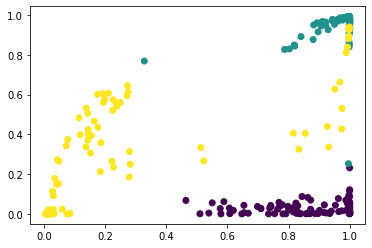

In [ ]:
N = Xtrain.shape[0]
A_pre =zeros([N,2])
for j in range(N):
  Y_hat, caches = forward_prop(Xtrain[j], params_square_new, activation = activation_function)
  A_pre[j], Z2 = caches[2]


scatter(A_pre[:,0],A_pre[:,1],c=Ytrain)   




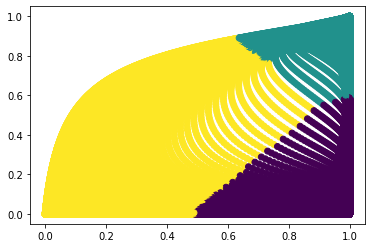

In [ ]:
  mins = Xtrain.min(axis=0) - 0.1
  maxs = Xtrain.max(axis=0) + 0.1
  xx, yy = np.meshgrid(linspace(mins[0], maxs[0], 300),
                       linspace(mins[1], maxs[1], 300))
  X_new = np.c_[xx.ravel(), yy.ravel()]
  Ypred = prediction(params_square_new, X_new)
  N = Ypred.shape[0]
  A_pre =zeros([N,2])
  for j in range(N):
    Y_hat, caches = forward_prop(X_new[j], params_square_new, activation = activation_function)
    A_pre[j], Z2 = caches[2]


  fig=figure()
  plt.scatter(A_pre[:,0],A_pre[:,1],c=Ypred)